#### Выгрузка данных и первичный анализ

In [100]:
from dotenv import load_dotenv
import os
import requests as rq
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [136]:
load_dotenv()

DATE_BEGIN = os.getenv('DATE_BEGIN')
DATE_END = os.getenv('DATE_END')
API_URL = os.getenv('API_URL')

current_dir = os.getcwd() 
charts_folder = os.path.join(current_dir, 'charts')

if not os.path.exists(charts_folder):
    os.makedirs(charts_folder)

v = rq.get(f'{API_URL}/visits', params={'begin': DATE_BEGIN, 'end': DATE_END})
r = rq.get(f'{API_URL}/registrations', params={'begin': DATE_BEGIN, 'end': DATE_END})

visits = pd.DataFrame(v.json())
regs = pd.DataFrame(r.json())

# Конверсия

#### Очистка и объединение данных визитов и регистраций по дате и платформе

In [137]:
def visits_clean(visits):
    visits = visits.sort_values('datetime').groupby('visit_id').tail(1)
    visits['date_group'] = pd.to_datetime(visits['datetime']).dt.date
    visits_agr = visits.drop(['datetime', 'user_agent'], axis=1)
    visits_agr = visits_agr.groupby(['date_group', 'platform']).agg(visits = ('visit_id', 'count'))
    visits_agr = visits_agr.reset_index()
    return visits_agr

def regs_clean(regs):
    regs['date_group'] = pd.to_datetime(regs['datetime']).dt.date
    regs_agr = regs.drop(['datetime', 'email', 'registration_type'], axis=1)
    regs_agr = regs_agr.groupby(['date_group', 'platform']).agg(registrations = ('user_id', 'count'))
    regs_agr = regs_agr.reset_index()
    return regs_agr

#### Расчет конверсии

In [138]:
def conversion(visits_agr, regs_agr):
    convers = pd.merge(left=visits_agr, right=regs_agr, on=('date_group', 'platform'))
    convers['conversion'] = convers['registrations'] * 100 / convers['visits']
    convers.to_json('./conversion.json')
    return convers

# Реклама

In [139]:
def ads_load():
    ads = pd.read_csv('ads.csv')
    ads['date_group'] = pd.to_datetime(ads['date']).dt.date
    return ads

def ads_conv(ads, convers):
    ads = ads.drop(['date', 'utm_source', 'utm_medium'], axis=1)
    convers_cut = convers.drop(['platform', 'conversion'], axis=1)
    ads_full = pd.merge(convers_cut, ads, on='date_group')
    ads_full['cost'] =ads_full['cost'].fillna(0)
    ads_full['utm_campaign'] =ads_full['utm_campaign'].fillna('none')
    conv_ads = pd.merge(convers, ads_full, on=('date_group', 'visits', 'registrations'))
    conv_ads.to_json('./ads.json')
    return conv_ads

# Визуализация

#### Общие визиты

In [140]:
def graph1(visits_agr):
    visits_agr = visits_agr.drop(['platform'], axis=1).groupby('date_group').sum().reset_index()
    plt.figure(figsize=(25,10))
    splot = sns.barplot(data=visits_agr, x='date_group', y='visits', color='lightgreen', errorbar = None)
    plt.xlabel('Date', size=22)
    plt.ylabel('Visitors count', size=20)
    plt.title('Total Visitors', size=20)
    plt.xticks([0, 31, 61, 92, 122, 153, 183], rotation=45, size=13)
    plt.yticks(size=13)
    plt.grid(axis='y')
    #plt.bar_label(splot.containers[0], size=12)
    plt.savefig('./charts/visits_by_date.png')
    plt.show()

#### Визиты по платформам

In [141]:
def conv_graphs(convers):
    convers['conversion'] = convers['conversion'].astype(int)
    over_conv = convers.drop(['conversion', 'platform'], axis=1).groupby('date_group').agg(visits=('visits', 'sum'), registrations=('registrations', 'sum')).reset_index()
    over_conv['conversion'] = round(over_conv['registrations'] / over_conv['visits']  * 100, 2)
    over_conv = over_conv.drop(['visits', 'registrations'], axis = 1)
    over_conv['conversion'] = over_conv['conversion'].astype(int)
    return over_conv

def stack_graph1(convers):
    con = convers.pivot_table(values='visits', index='date_group', columns='platform', aggfunc='sum', fill_value=0)
    fig, ax = plt.subplots(figsize=(25, 10))
    con.plot(kind='bar', stacked=True, ax=ax, edgecolor='white')
    ax.set_xlabel('Date', size=20)
    ax.set_ylabel('Visits', size=20)
    ax.set_title('Visits by Platform', size=22)
    plt.yticks(size=13)
    plt.legend(fontsize=20)
    plt.xticks([0, 31, 61, 92, 122, 153, 183], rotation=45, size=13)
    plt.savefig('./charts/visits_by_platform.png')
    plt.show()

#### Общие регистрации

In [142]:
def graph2(regs_agr):
    regs_agr = regs_agr.drop(['platform'], axis=1).groupby('date_group').sum().reset_index()
    plt.figure(figsize=(25,10))
    splot = sns.barplot(data=regs_agr, x='date_group', y='registrations', color='lightblue', errorbar = None)
    plt.xlabel('Date', size=22)
    plt.ylabel('Registrations count', size=20)
    plt.title('Total Registrations', size=20)
    plt.xticks([0, 31, 61, 92, 122, 153, 183], rotation=45, size=13)
    plt.yticks(size=13)
    plt.grid(axis='y')
    #plt.bar_label(splot.containers[0], size=12)
    plt.savefig('./charts/registrations_by_date.png')
    plt.show()

#### Регистрации по платформам

In [143]:
def stack_graph2(convers):
    con = convers.pivot_table(values='registrations', index='date_group', columns='platform', aggfunc='sum', fill_value=0)
    fig, ax = plt.subplots(figsize=(25, 10))
    con.plot(kind='bar', stacked=True, ax=ax, edgecolor='white')
    ax.set_xlabel('Date', size=20)
    ax.set_ylabel('Registrations', size=20)
    ax.set_title('Registrations by Platform', size=22)
    plt.yticks(size=13)
    plt.legend(fontsize=20)
    plt.xticks([0, 31, 61, 92, 122, 153, 183], rotation=45, size=13)
    plt.savefig('./charts/registrations_by_platform.png')
    plt.show()

#### Общая конверсия

In [144]:
def conv_graph(over_conv):
    plt.figure(figsize=(25, 10))

    plt.plot('date_group', 'conversion', data=over_conv, marker='o', markersize = 9, color='mediumblue', markerfacecolor='r', label='Общая конверсия')

    plt.xlabel('Date', size=20)
    plt.ylabel('Conversion (%)', size=20)
    plt.title('Overall Conversion', size=22)
    plt.legend(fontsize=18)
    plt.xticks(rotation=45, size=13)
    plt.yticks(size=13)
    plt.grid()

    #for i, txt in enumerate(df[y]):
        #plt.annotate(f'{txt}%', (df[x][i], df[y][i]), 
                     #textcoords="offset points", xytext=(0,10), ha='center', size=16)
    plt.savefig('./charts/overall_conversion.png')
    plt.show()

#### Конверсия по платформам

In [145]:
def androin_conv_graph(convers):
    android_conv = convers.iloc[0::3].drop(['platform', 'visits', 'registrations'], axis=1)

    plt.figure(figsize=(25, 10))

    plt.plot('date_group', 'conversion', data=android_conv, marker='o', markersize = 9, color='darkgreen', markerfacecolor='r', label='android')

    plt.xlabel('Date', size=20)
    plt.ylabel('Conversion (%)', size=20)
    plt.title('Conversion android', size=22)
    plt.legend(fontsize=18)
    plt.xticks(rotation=45, size=13)
    plt.yticks(size=13)
    plt.grid()

    #for i, txt in enumerate(df[y]):
        #plt.annotate(f'{txt}%', (df[x].iloc[i], df[y].iloc[i]), 
                     #textcoords="offset points", xytext=(0,10), ha='center', size=16)
    plt.savefig('./charts/android_conversion.png')
    plt.show()

In [146]:
def ios_conv_graph(convers):
    ios_conv = convers.iloc[1::3].drop(['platform', 'visits', 'registrations'], axis=1)

    plt.figure(figsize=(25, 10))

    plt.plot('date_group', 'conversion', data=ios_conv, marker='o', markersize = 9, color='darkviolet', markerfacecolor='r', label='ios')

    plt.xlabel('Date', size=20)
    plt.ylabel('Conversion (%)', size=20)
    plt.title('Conversion ios', size=22)
    plt.legend(fontsize=18)
    plt.xticks(rotation=45, size=13)
    plt.yticks(size=13)
    plt.grid()

    #for i, txt in enumerate(df[y]):
        #plt.annotate(f'{txt}%', (df[x].iloc[i], df[y].iloc[i]), 
                     #textcoords="offset points", xytext=(0,10), ha='center', size=16)
    plt.savefig('./charts/ios_conversion.png')
    plt.show()

In [147]:
def web_conv_graph(convers):
    web_conv = convers.iloc[2::3].drop(['platform', 'visits', 'registrations'], axis=1)

    plt.figure(figsize=(25, 10))

    plt.plot('date_group', 'conversion', data=web_conv, marker='o', markersize = 9, color='sienna', markerfacecolor='r', label='web')

    plt.xlabel('Date', size=20)
    plt.ylabel('Conversion (%)', size=20)
    plt.title('Conversion web', size=22)
    plt.legend(fontsize=18)
    plt.xticks(rotation=45, size=13)
    plt.yticks(size=13)
    plt.grid()

    #for i, txt in enumerate(df[y]):
        #plt.annotate(f'{txt}%', (df[x].iloc[i], df[y].iloc[i]), 
                     #textcoords="offset points", xytext=(0,10), ha='center', size=16)
    plt.savefig('./charts/web_conversion.png')
    plt.show()

#### Стоимость рекламы

In [148]:
def ads_graphs(ads):
    ads_graph = ads.drop(['utm_campaign'], axis=1)
    
    plt.figure(figsize=(25, 10))

    plt.plot('date_group', 'cost', data=ads_graph, marker='o', color='navy', markersize=9, markerfacecolor='r')

    plt.xlabel('Date', size=20)
    plt.ylabel('Cost (RUB)', size=20)
    plt.title('Aggregated Ad Compaign Cost', size=22)
    plt.xticks(rotation=45, size=13)
    plt.yticks(size=13)
    plt.grid()

#for i, txt in enumerate(ads_graph['cost']):
    #plt.annotate(f'{txt}RUB', (ads_graph['date_group'][i], ads_graph['cost'][i]), 
                 #textcoords="offset points", xytext=(0,10), ha='center', size=16)
    plt.savefig('./charts/ad_cost.png')
    plt.show()

#### Количество визитов в активные рекламные дни

In [149]:


def market_graph1(conv_ads):
    vis_ads_utm = conv_ads.drop(['platform', 'registrations', 'conversion', 'cost'], axis=1).groupby(['date_group', 'utm_campaign']).agg(visits = ('visits', 'sum')).reset_index()
    vis_ads_utm['average'] = round(vis_ads_utm['visits'].mean())
    utm = (vis_ads_utm.groupby(['utm_campaign'], as_index=False)
        .agg(**{'first':('date_group', 'first'),
                'last': ('date_group', 'last')}))
    fig, ax = plt.subplots(figsize=(25, 10))
    ax.plot( vis_ads_utm['date_group'],  vis_ads_utm['visits'], color='black', marker='o',label='Visits')
    ax.plot( vis_ads_utm['date_group'],  vis_ads_utm['average'], color='r', linestyle = '-.', label='Average')

    plt.xlabel('Date', size=22)
    plt.ylabel('Visits', size=20)
    plt.title('Visits during marketing active days', size=22)
    plt.xticks(rotation=45, size=13)
    plt.yticks(size=13)
    plt.grid()

    utm_started = utm['first'].to_list()
    utm_ended = utm['last'].to_list()
    for i in range(len(utm)):
        ax.axvspan(utm_started[i], utm_ended[i], alpha=0.3, color=np.random.rand(3,), label=utm['utm_campaign'].to_list()[i] )

    plt.legend(fontsize=16)
    plt.savefig('./charts/visits_during_marketing.png')
    plt.show()

#### Количество регистраций в активные рекламные дни

In [150]:
def market_graph2(conv_ads):
    reg_ads_utm = conv_ads.drop(['platform', 'visits', 'conversion', 'cost'], axis=1).groupby(['date_group', 'utm_campaign']).agg(registrations = ('registrations', 'sum')).reset_index()
    reg_ads_utm['average'] = round(reg_ads_utm['registrations'].mean())
    utm = (reg_ads_utm.groupby(['utm_campaign'], as_index=False)
        .agg(**{'first':('date_group', 'first'),
                'last': ('date_group', 'last')}))
    fig, ax = plt.subplots(figsize=(25, 10))
    ax.plot(reg_ads_utm['date_group'], reg_ads_utm['registrations'], color='black', marker='o',label='Registrations')
    ax.plot(reg_ads_utm['date_group'], reg_ads_utm['average'], color='r', linestyle = '-.', label='Average')

    plt.xlabel('Date', size=22)
    plt.ylabel('Registrations', size=20)
    plt.title('Registrations during marketing active days', size=22)
    plt.xticks(rotation=45, size=13)
    plt.yticks(size=13)
    plt.grid()

    utm_started = utm['first'].to_list()
    utm_ended = utm['last'].to_list()
    for i in range(len(utm)):
        ax.axvspan(utm_started[i], utm_ended[i], alpha=0.3, color=np.random.rand(3,), label=utm['utm_campaign'].to_list()[i] )

    plt.legend(fontsize=16)
    plt.savefig('./charts/registrations_during_marketing.png')
    plt.show()

#### Вывод всех графиков

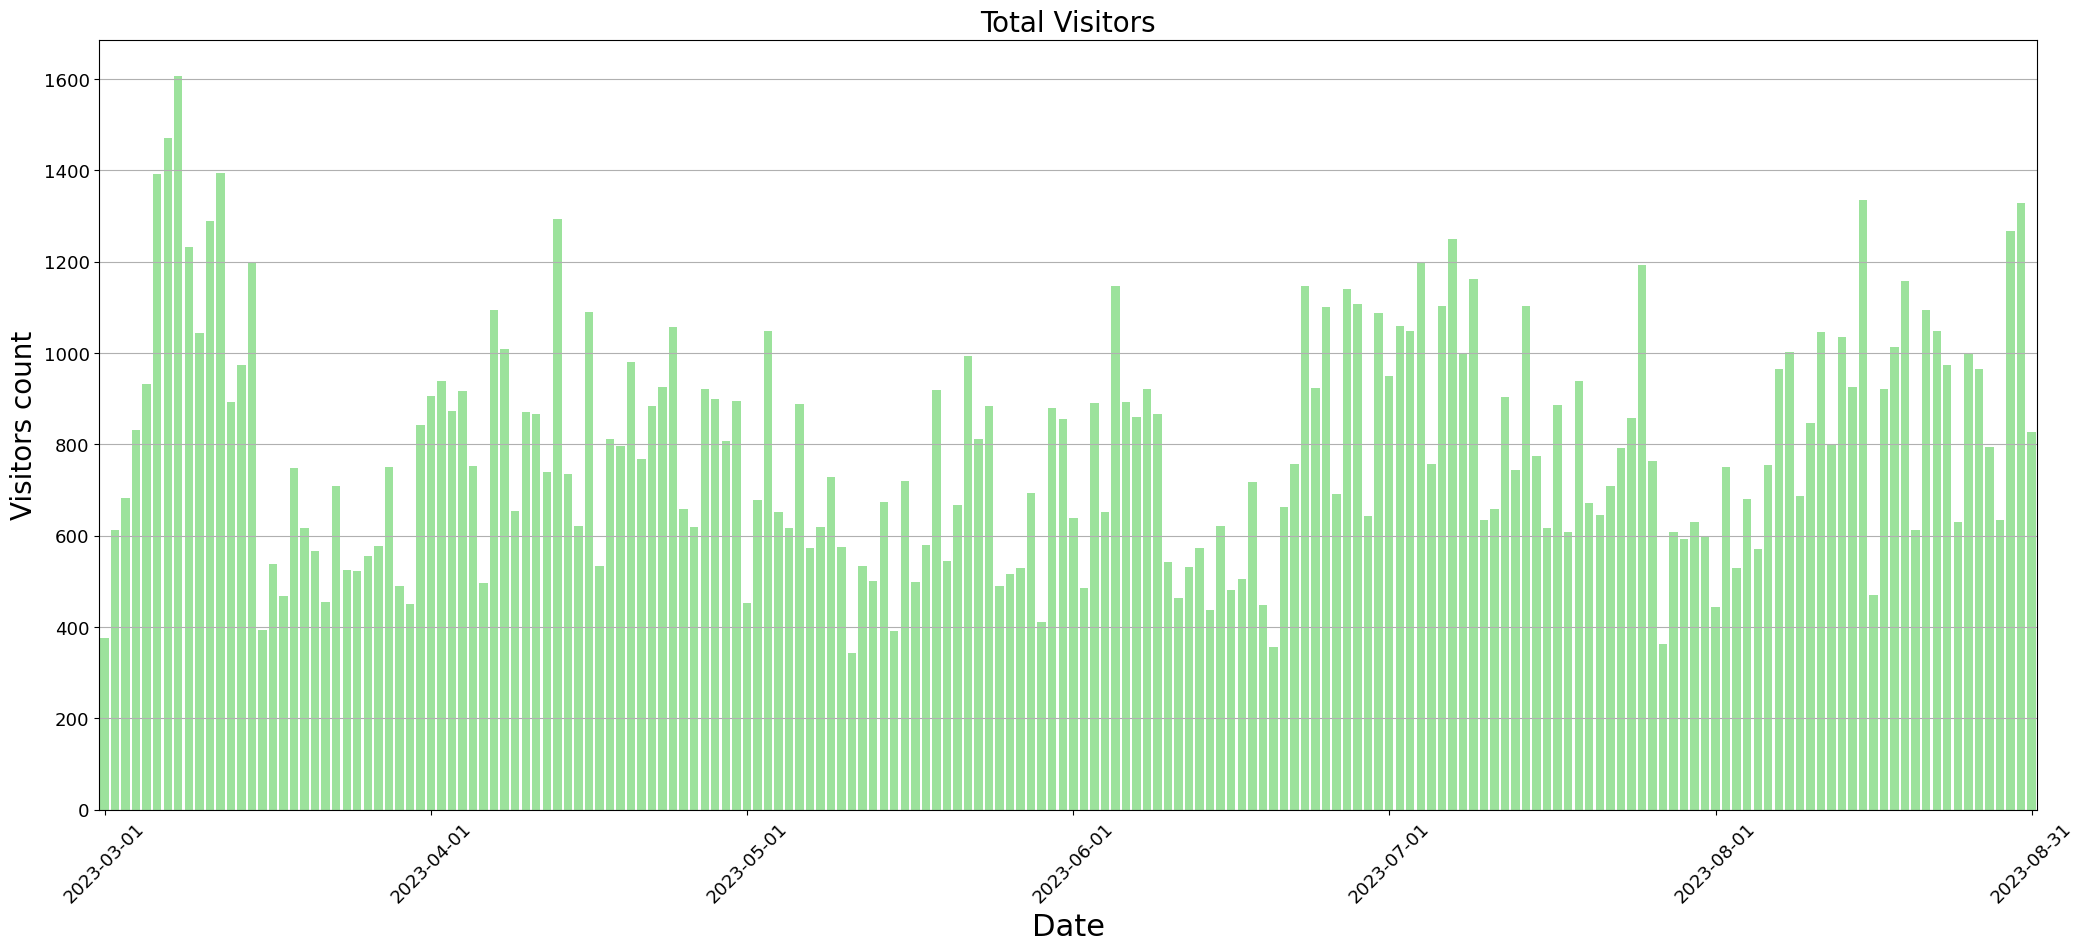

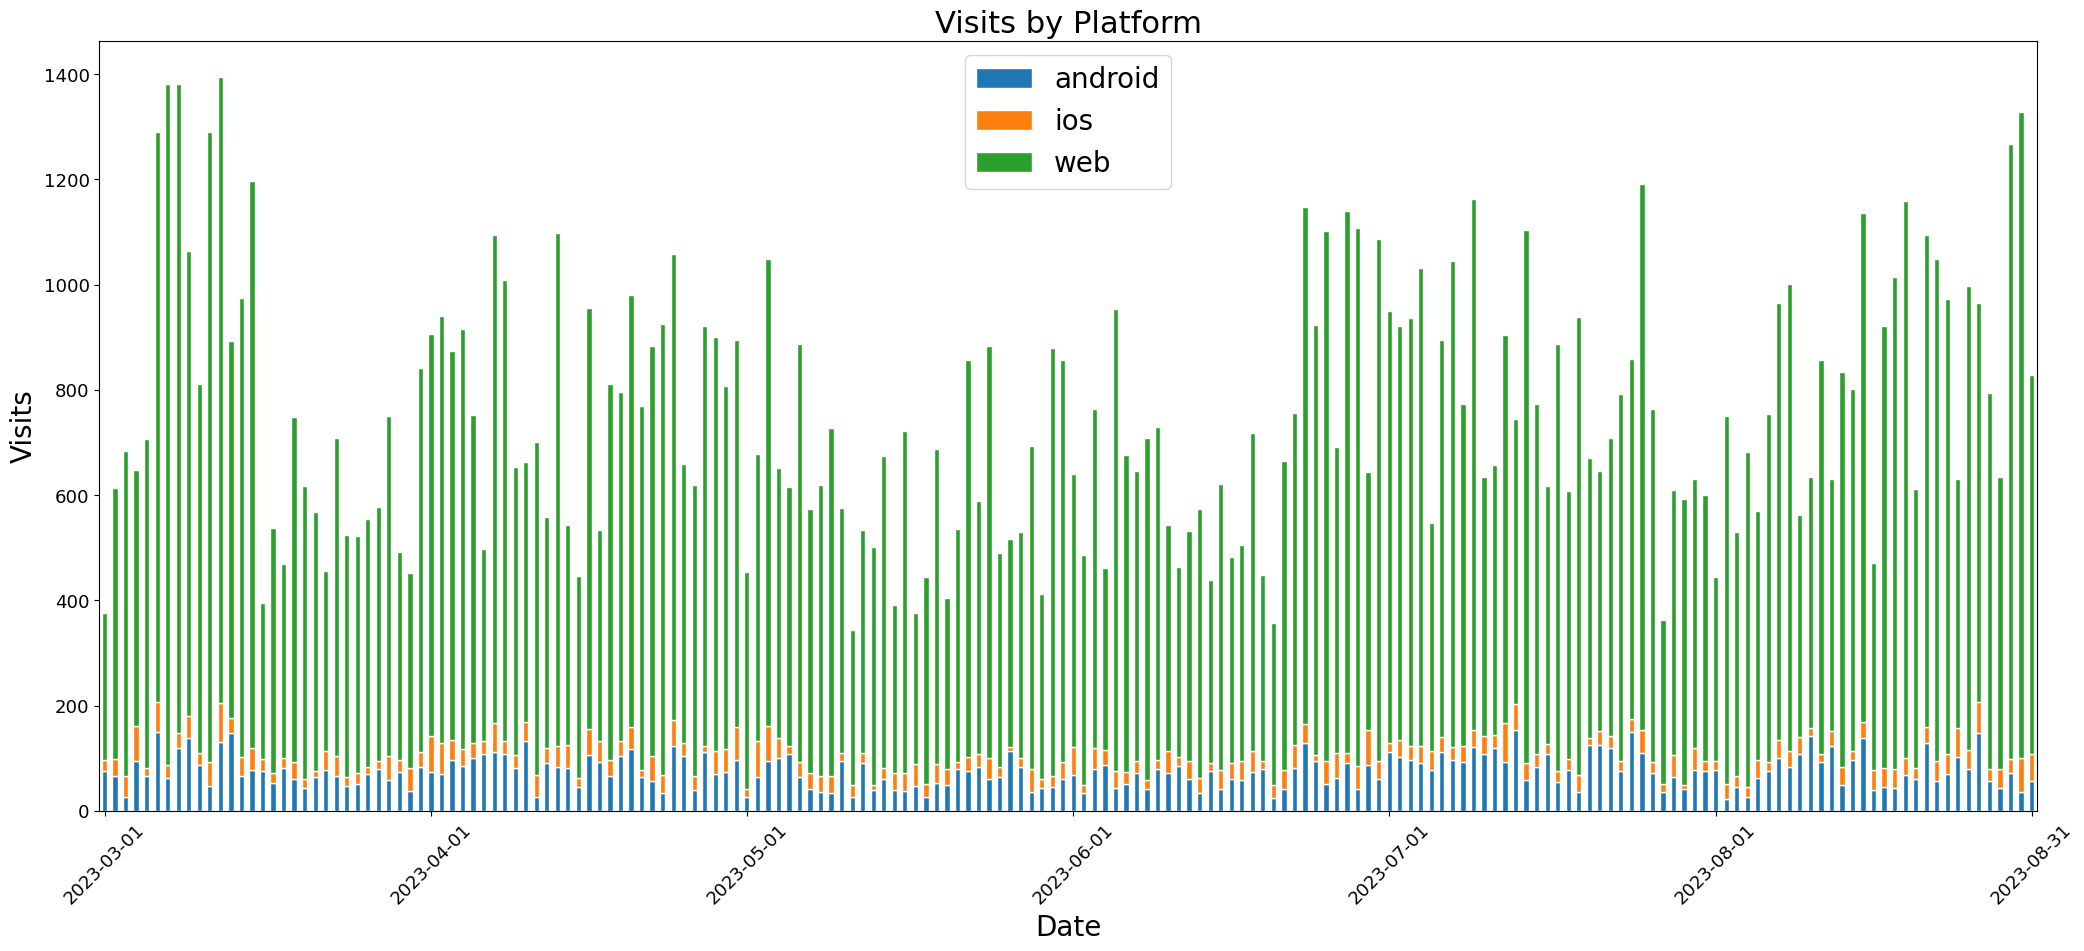

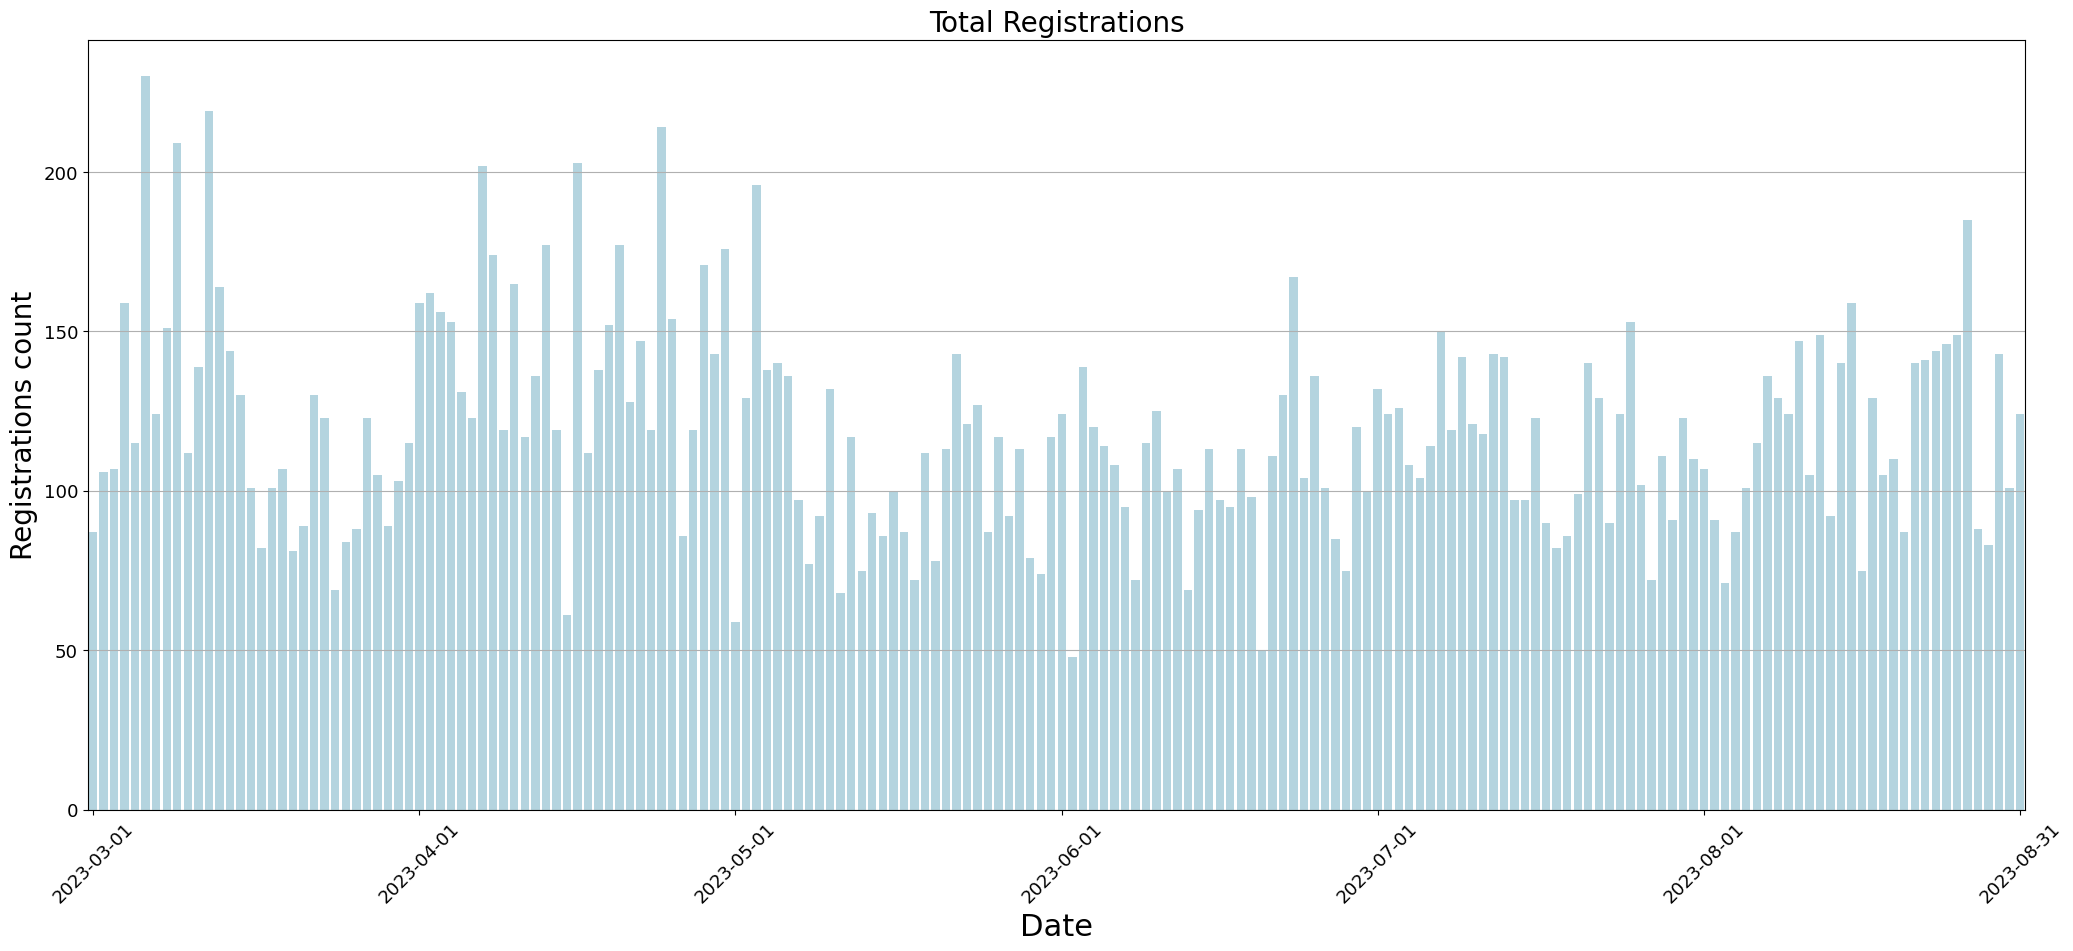

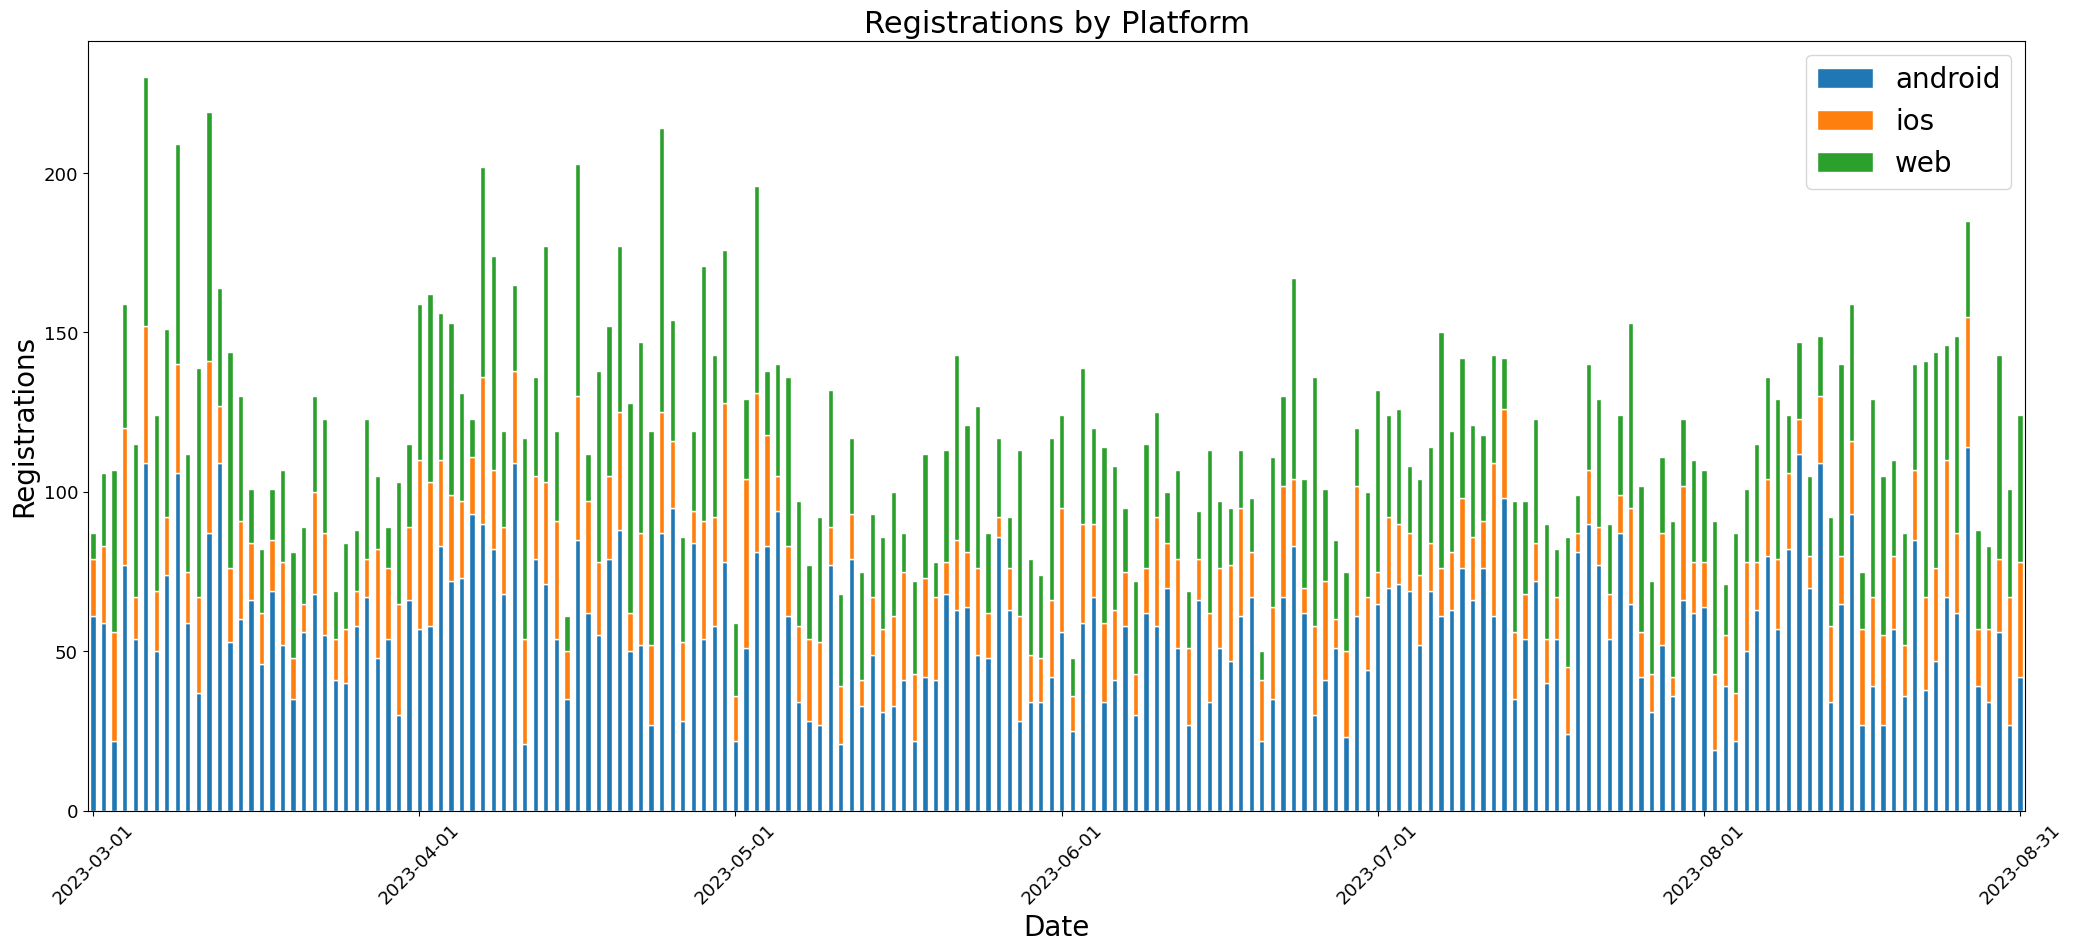

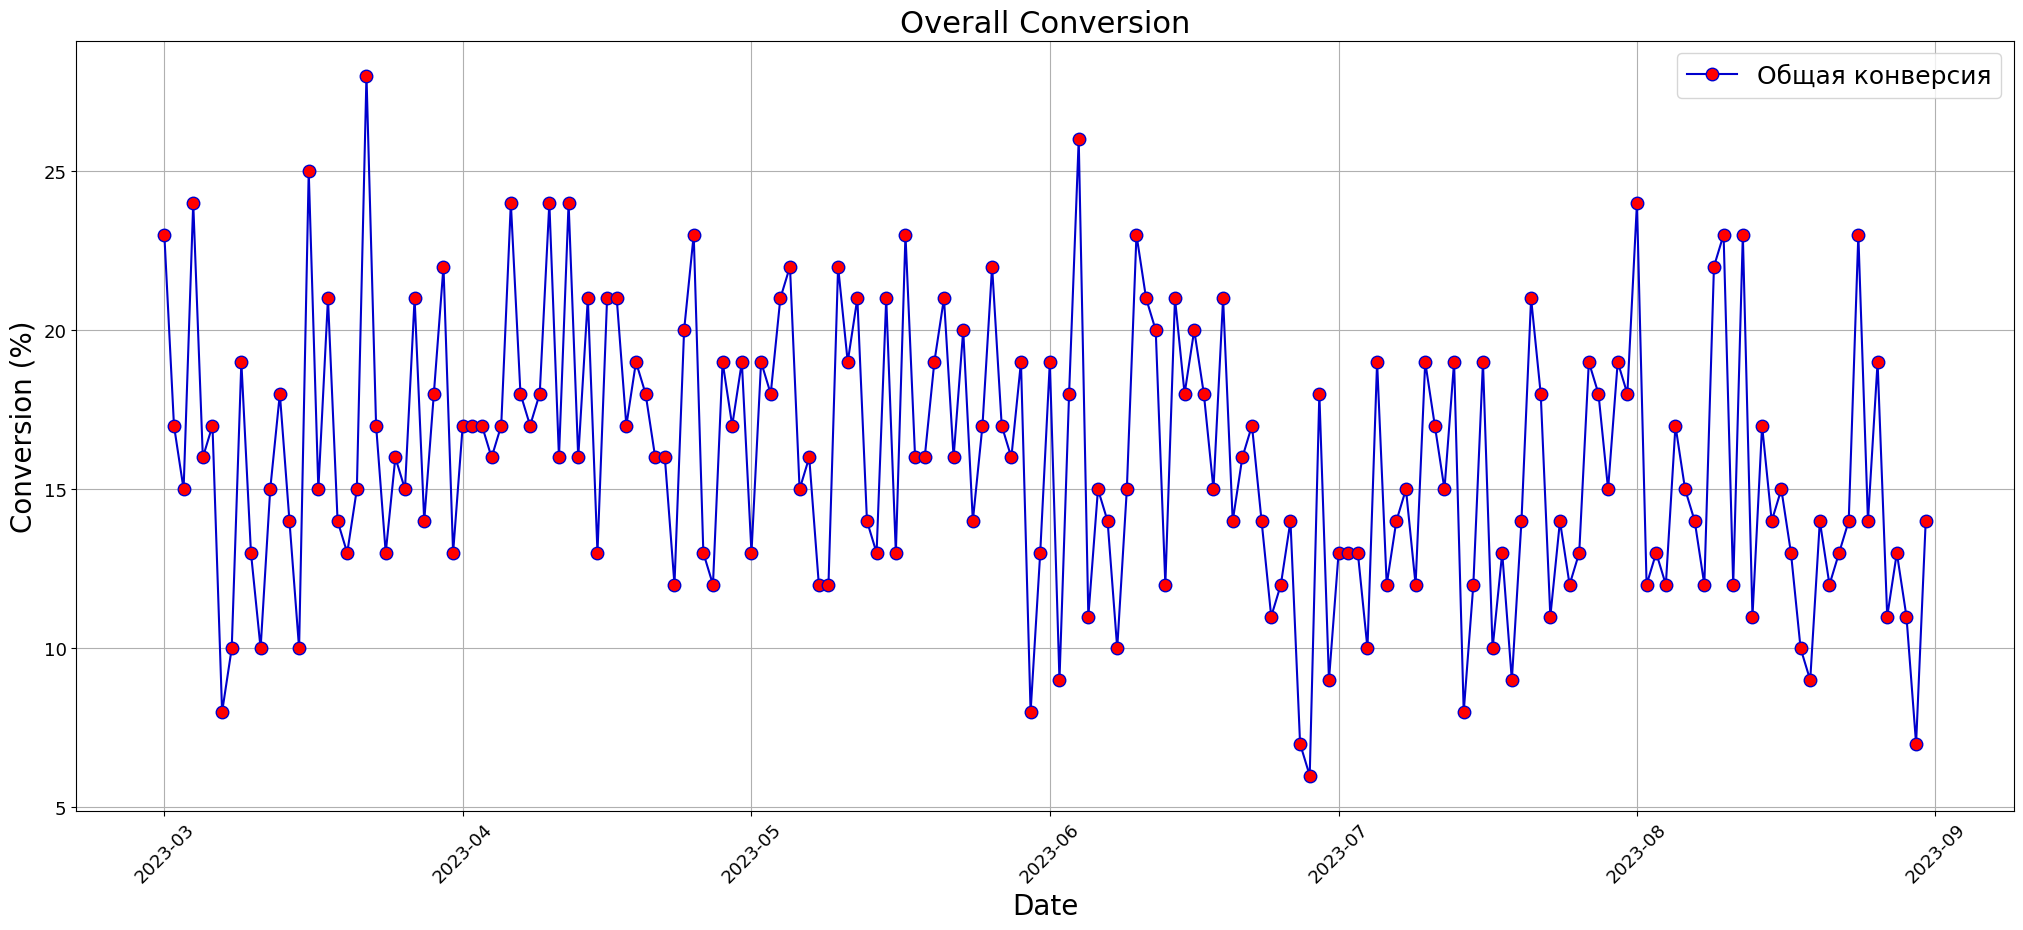

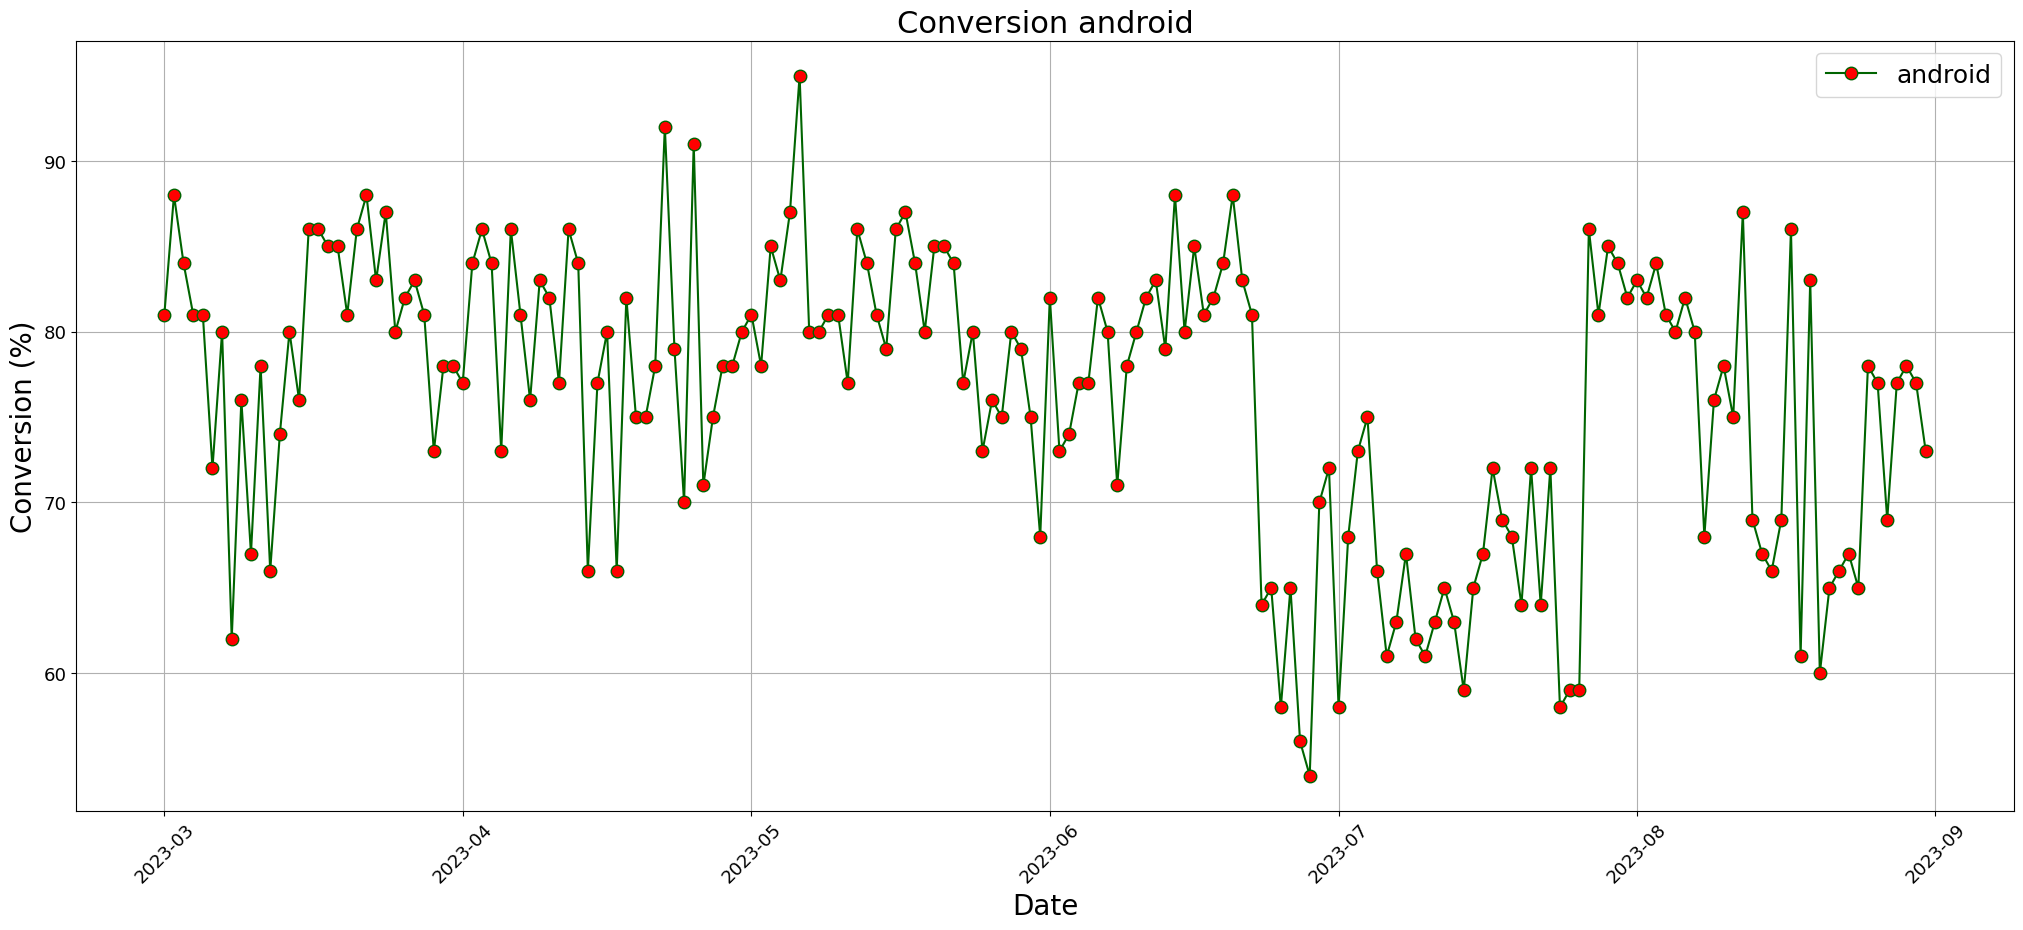

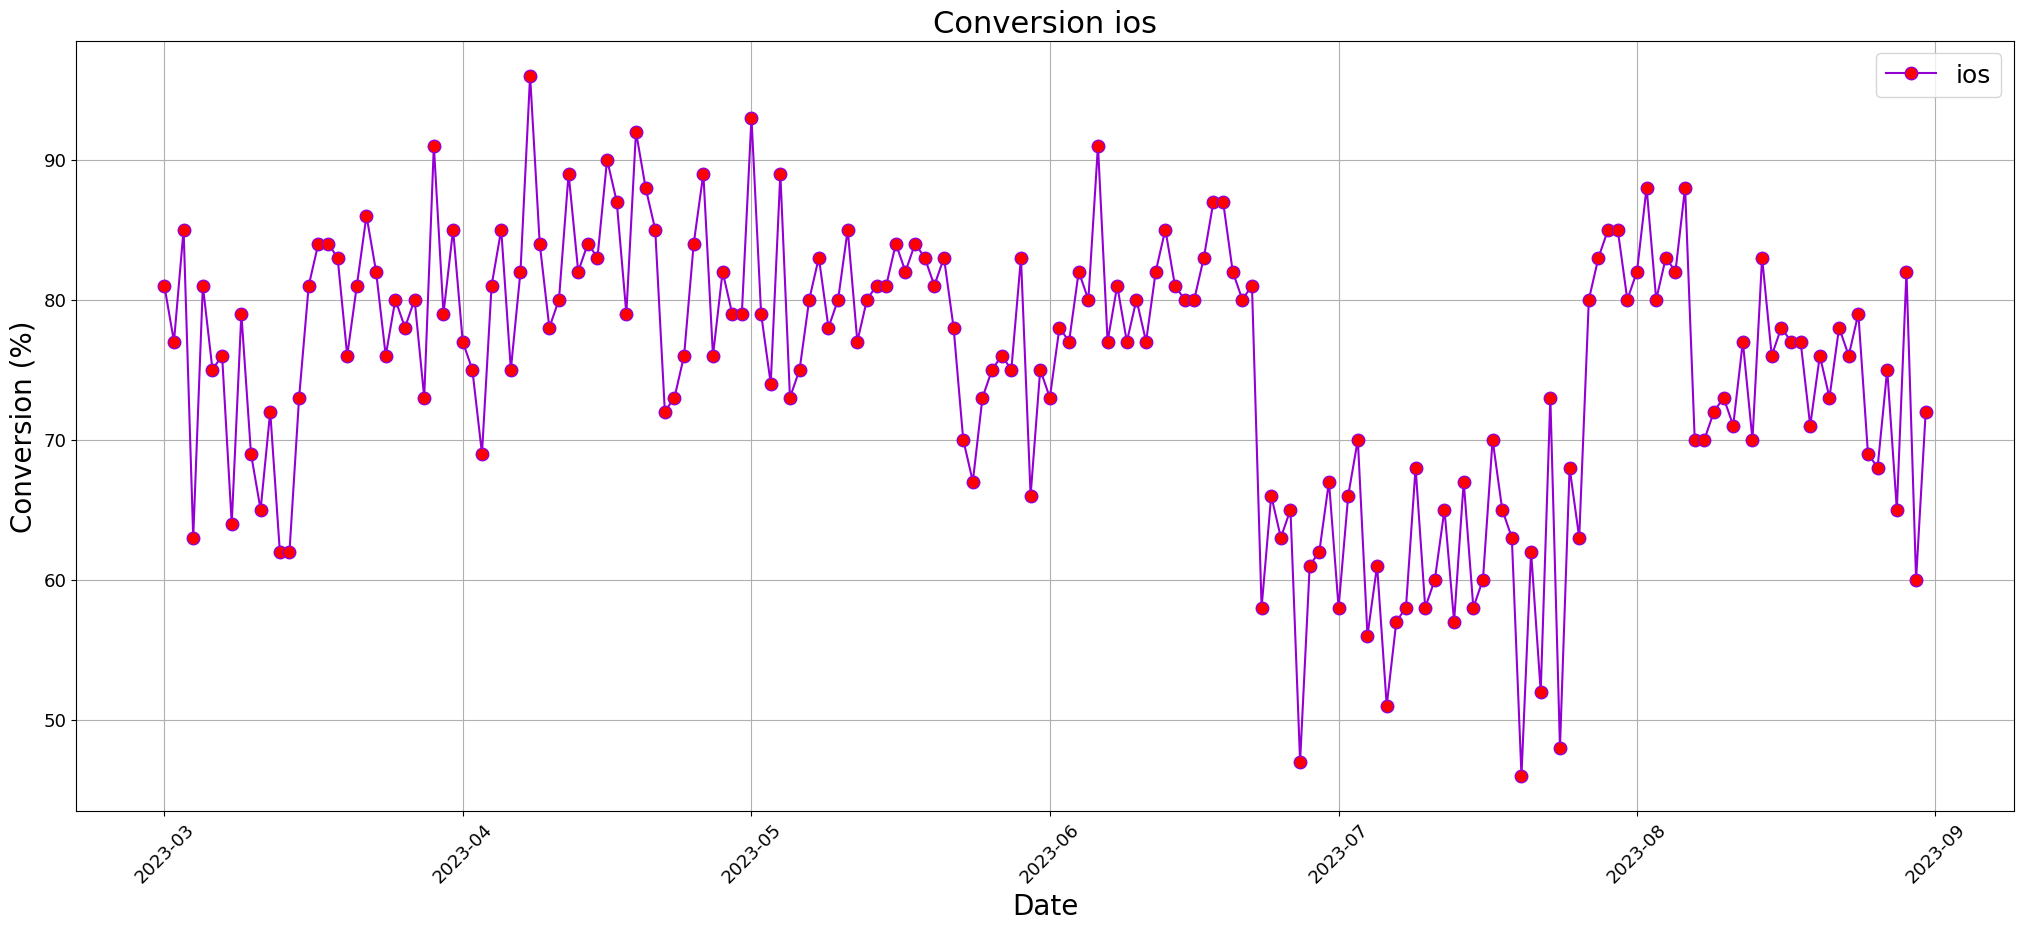

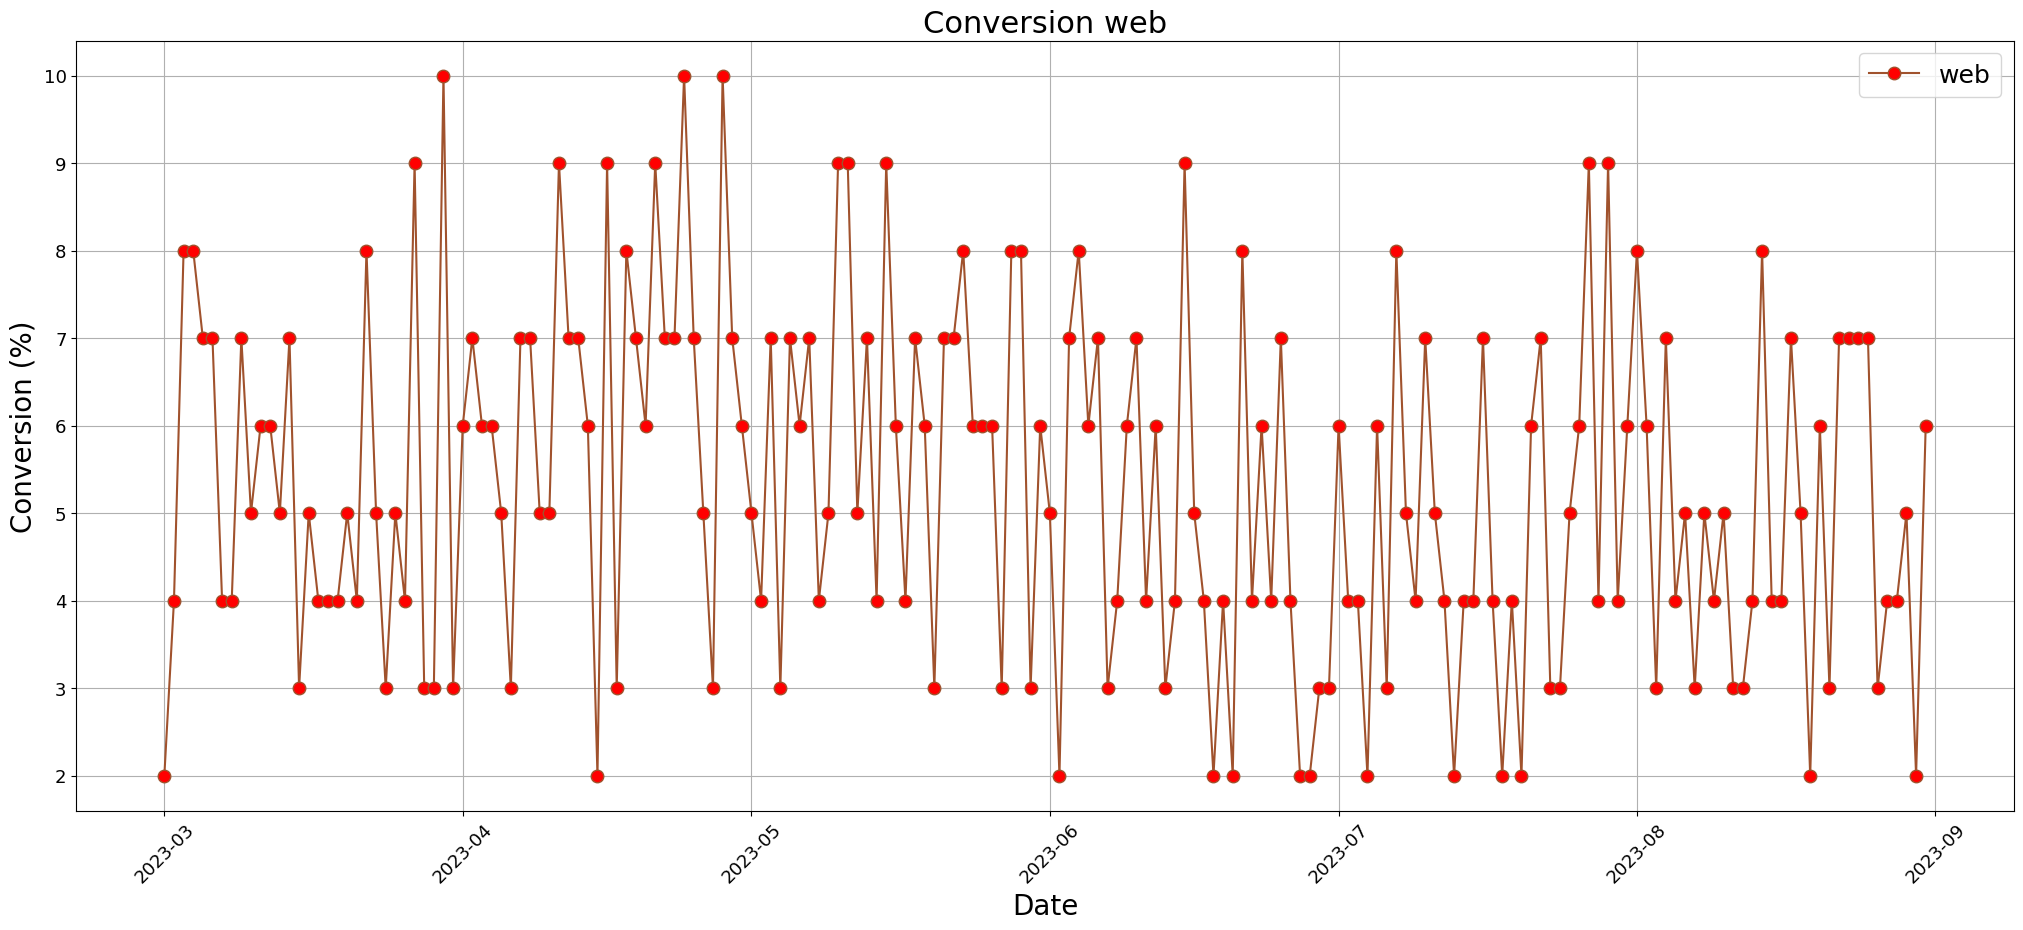

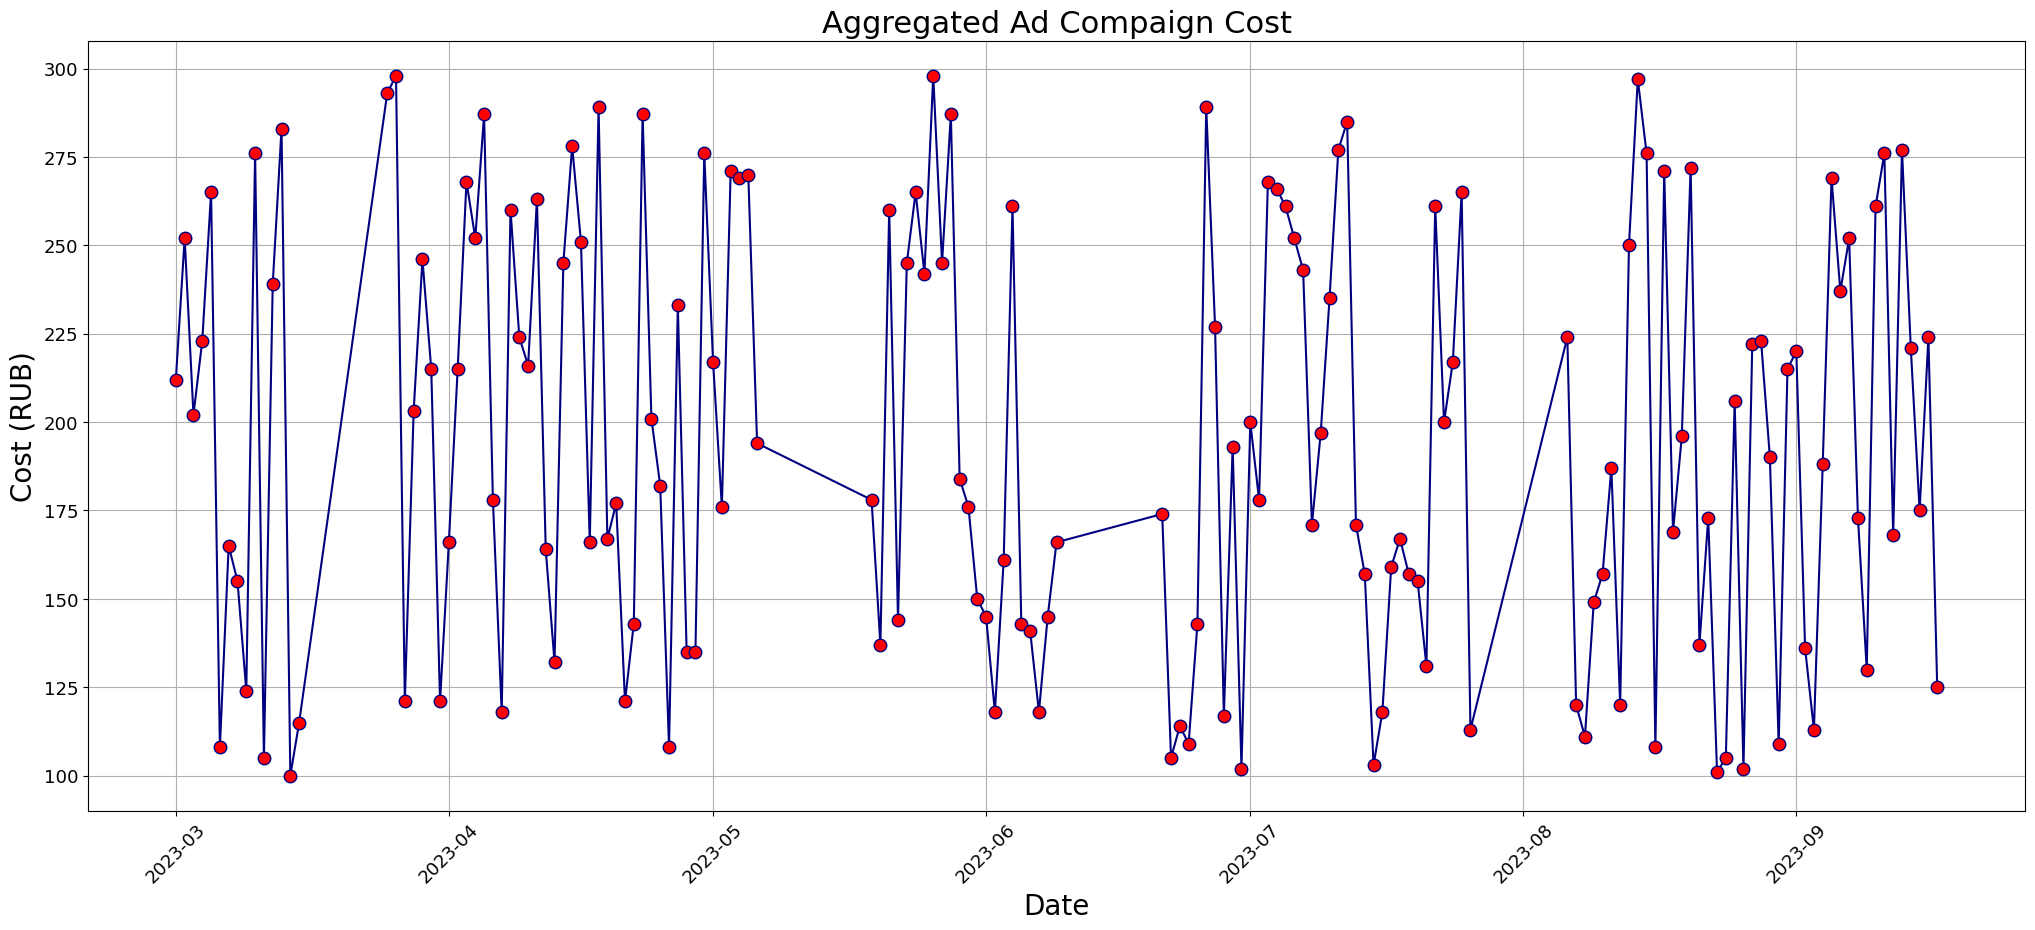

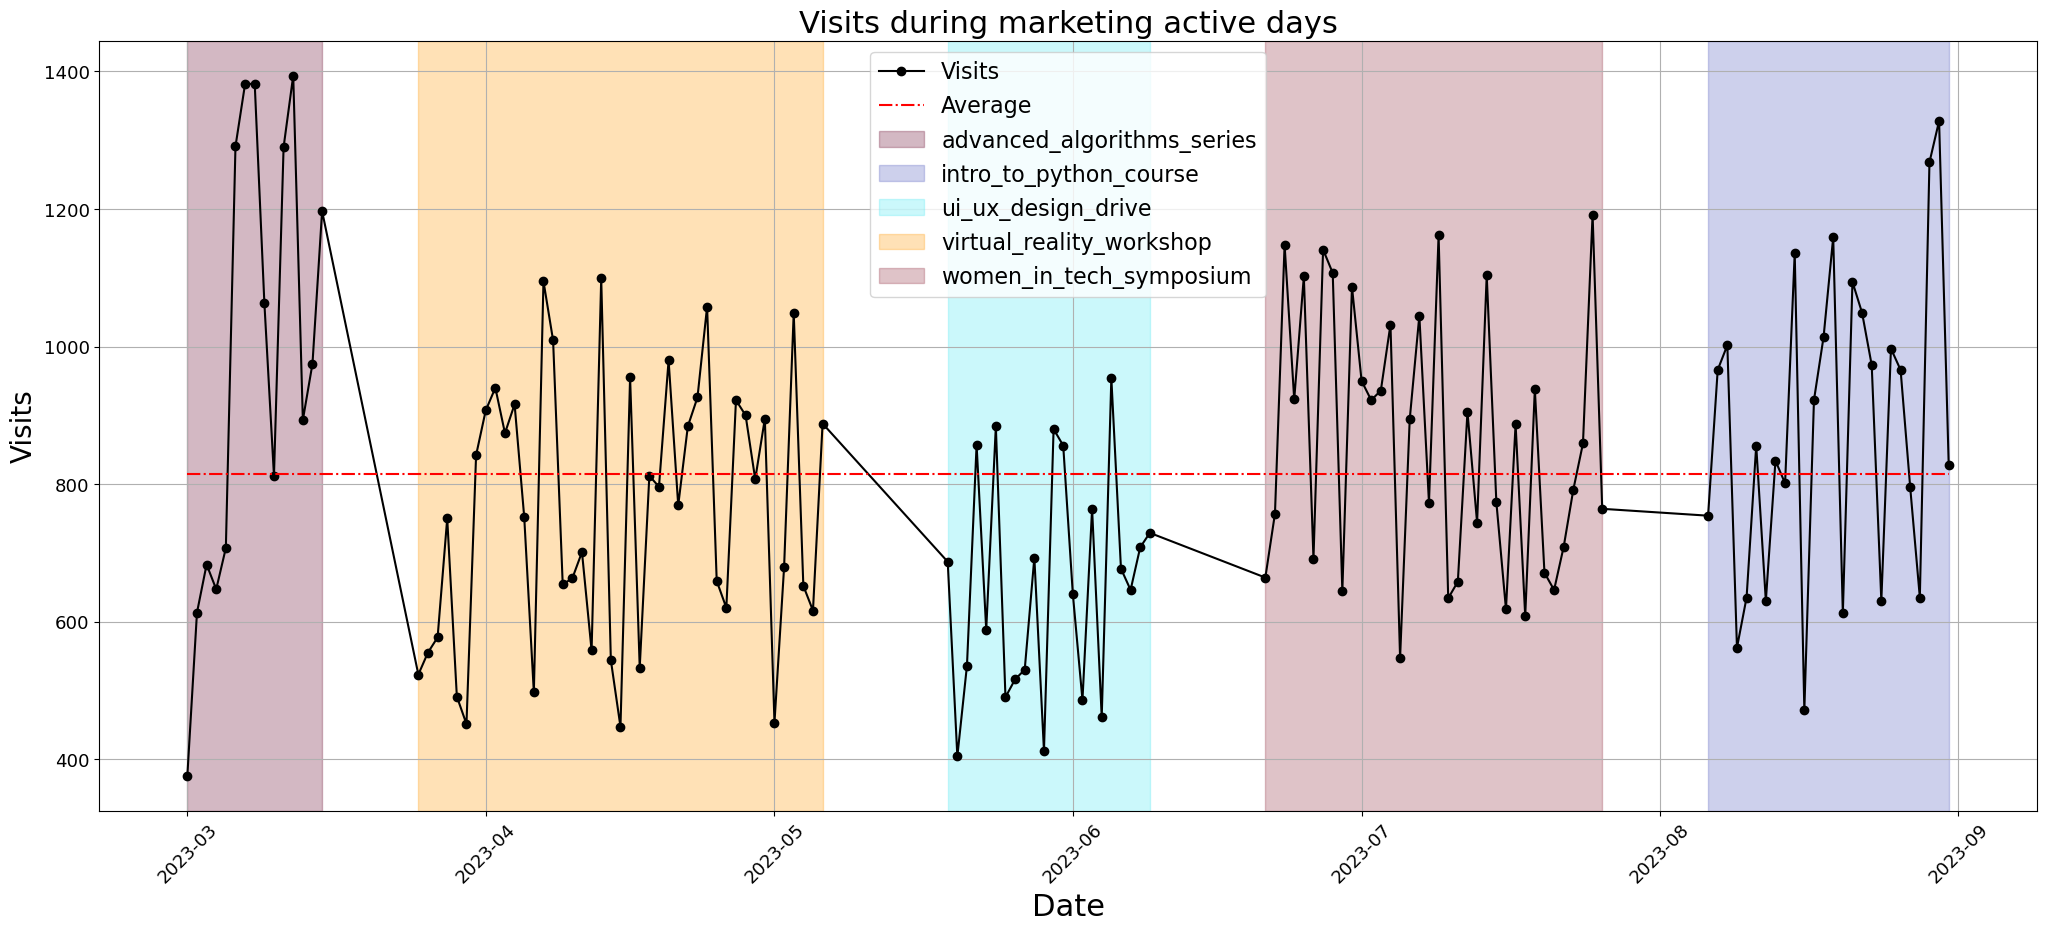

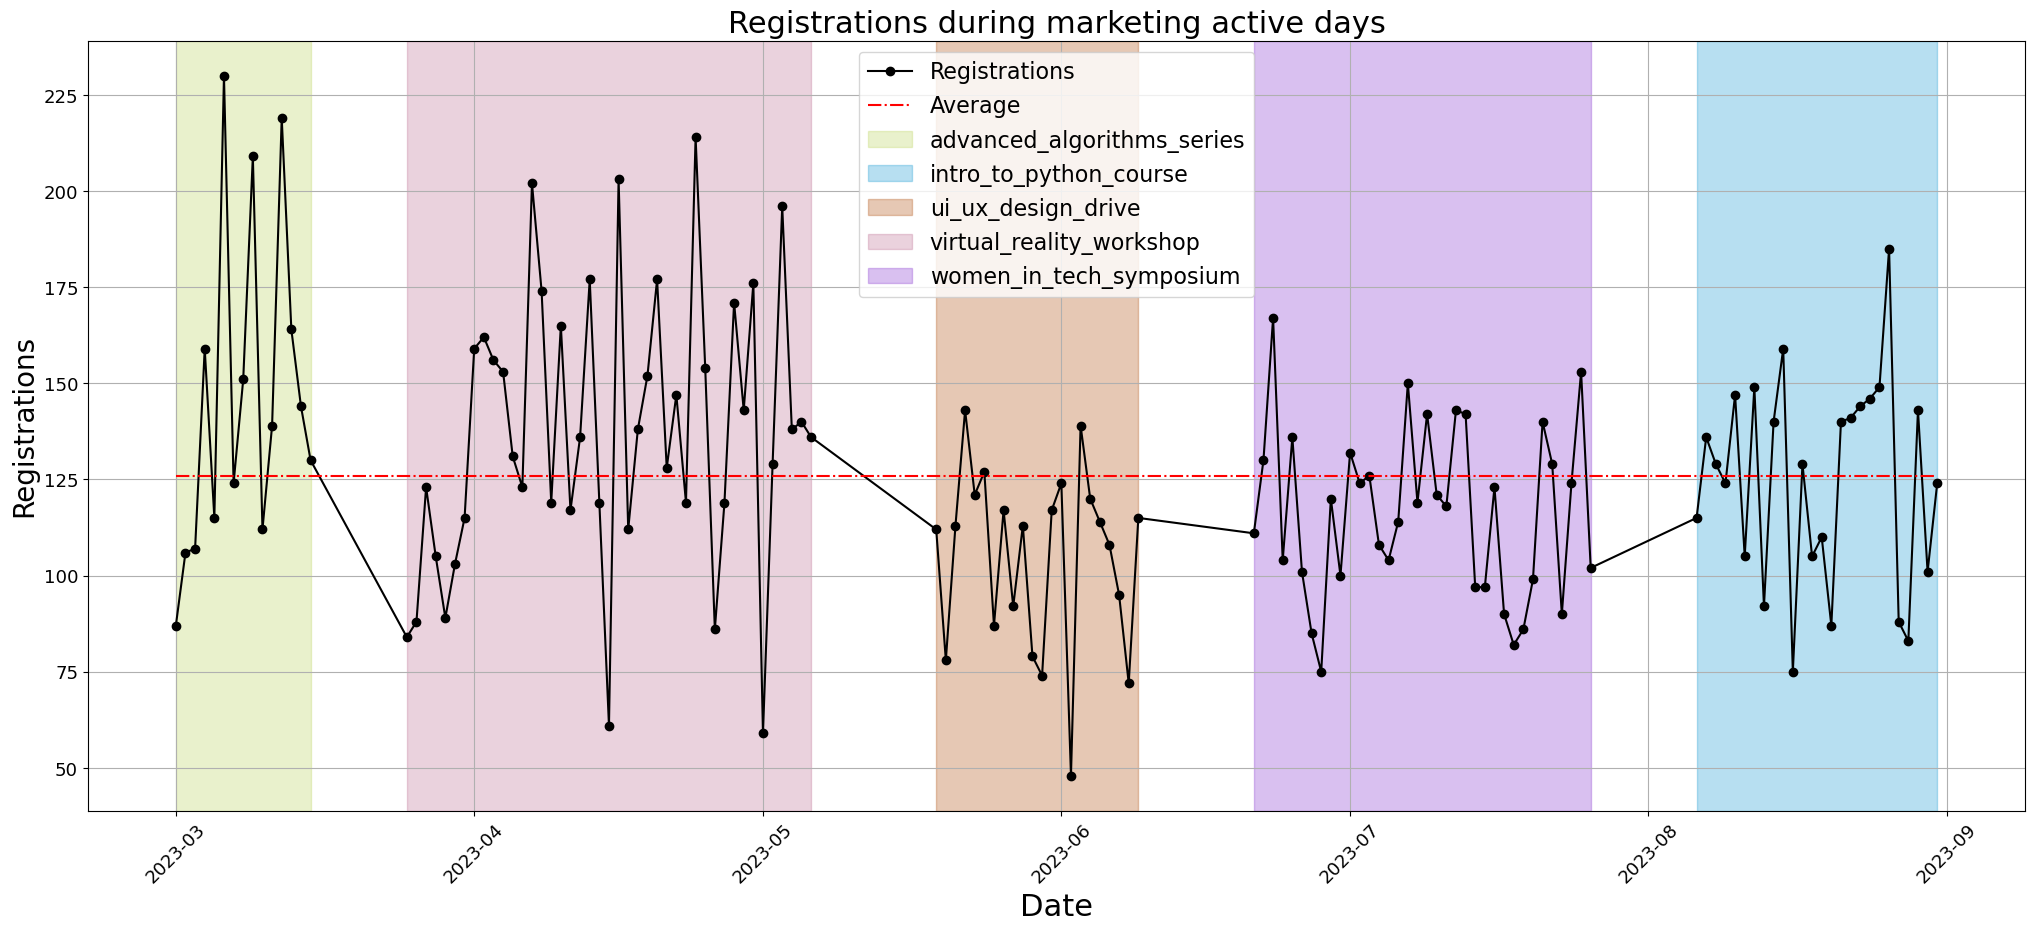

In [151]:
def all_graph():
    visits_agr = visits_clean(visits)
    regs_agr = regs_clean(regs)
    convers = conversion(visits_agr, regs_agr)
    ads = ads_load()
    conv_ads = ads_conv(ads, convers)
    over_conv = conv_graphs(convers)

    graph1(visits_agr)
    stack_graph1(convers)
    graph2(regs_agr)
    stack_graph2(convers)
    conv_graph(over_conv)
    androin_conv_graph(convers)
    ios_conv_graph(convers)
    web_conv_graph(convers)
    ads_graphs(ads)
    market_graph1(conv_ads)
    market_graph2(conv_ads)

if __name__ == "__main__":
    all_graph()